### Coursera/IBM Capstone Final Project

This notebook will serve a preliminary draft to the final documents to be submitted for review. I'll mostly sketch out the ideas for the report and include code chunks that will help with collecting and analyzing the data. 

#### Main Idea for the Project:

In the same way venues in the Tornto, CA area were aggregated and clustered, the same task will be carried out for the greater Chichago area. In this way we can examine the different characteristics of the towns/neighborhoods of Chicago. This may provide useful information regarding business characteristics. 

The location data will be scraped from the web, namely zip codes/neighborhood names will be obtained, along with their corresponding geographic coordinates.

The coordinates will be used to access the venue information from the Foursquare API, so that the neighborhoods can be clustered.

If possible, real-estate information/data will be obtained (i.e. price information on commerical and residental real-estate) and perhaps some demographic information. This would be aggregated with the venue analysis to determine where it may be best for a company to locate in the greater Chichago area. One would hope that the company can be advised about he best priced, but also have the best access to venues.

Let's take care of importing the relavent libraries for analysis:

In [370]:
import pandas as pd
import numpy as np
import folium
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

### Getting the Chicago Area Geographic Data

In the same way the Toronto data was obtained in the previous assingment, the geographic information for the neighborhoods/zip codes/towns/villages in Cook County and Neighborhoods within Cicago, i.e. the greater Chichago are will be obtained from web sources.

In [2]:
#cook_zips = pd.read_html('', header = 0)[1]
#cook_zips

Let's look at the Neighborhoods of the City of Chicago:

In [133]:
chicago_neigh = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', header = 0)[0]
chicago_neigh = chicago_neigh.rename(columns = {"Number[8]": "Number", "Name[8]" : "CommunityArea", "2017[9]": "2017 Population", "Area (sq mi.)[10]": "Area (sq mi.)"})
chicago_neigh.iloc[31, 1] = 'The Loop'
chicago_neigh.head()

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59


Now, we'll find the geographic coordinates of each of these neighborhoods, but furst a test of the `Nominatim` and `geocode` functions:

In [178]:
geolocator = Nominatim(user_agent = 'chicago_app_test')
location = geolocator.geocode('The Loop, Chicago, IL, USA')
print((location.latitude, location.longitude))

(41.8816094, -87.6294574)


In [189]:
geolocator = Nominatim(user_agent = 'chicago_app_test')
location = geolocator.geocode(chicago_neigh.CommunityArea[6] + ', Chicago, IL, USA')
print((location.latitude, location.longitude))

(41.9216992, -87.647832)


The `geolocator.geocode` is a little squirly when it comes to looking up zip-codes baded on a community area name, therefore we have to go in a bit of a circle: once the coordinates are obtain for a community area, we use the cooordinates to get the zip code by parsing the `display_name` information.

In [252]:
geolocator = Nominatim(user_agent = 'chicago_app_test')
location = geolocator.geocode('41.975989850000005 , -87.6896163305115')
int(location.raw['display_name'].split(",")[-2][0:6])

9020

In [251]:
str(chicago_neigh.Latitude[3]) + " , "+ str(chicago_neigh.Longitude[3])

'41.975989850000005 , -87.6896163305115'

Checking this in Google Maps gives the expected result, now we do it for the rest of the neighborhoods:

In [193]:
chicago_neigh['Latitude']  = chicago_neigh.apply(lambda row: geolocator.geocode(row.CommunityArea + ', Chicago, IL, USA').latitude,  axis = 1)
chicago_neigh['Longitude'] = chicago_neigh.apply(lambda row: geolocator.geocode(row.CommunityArea + ', Chicago, IL, USA').longitude, axis = 1)
chicago_neigh.head()

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.010531,-87.670748
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20,42.003548,-87.696243
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06,41.966630,-87.655546
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.975990,-87.689616
4,05,North Center,35789,2.05,5.31,17458.05,6740.59,41.956107,-87.679160


In [247]:
zipcodes = np.zeros(len(chicago_neigh))

for rows in range(len(chicago_neigh)):
    lat, lng = chicago_neigh.Latitude[rows], chicago_neigh.Longitude[rows]
    query = str(lat) + " "+ str(lng)
    location = geolocator.geocode(query)
    zipcodes[rows] = int(location.raw['display_name'].split(",")[-2][0:6])

In [270]:
chicago_neigh['ZipCode'] = zipcodes
chicago_neigh.head()

,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude,ZipCode
0,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.010531,-87.670748,60645.0
1,West Ridge,76215,3.53,9.14,21590.65,8336.20,42.003548,-87.696243,60645.0
2,Uptown,57973,2.32,6.01,24988.36,9648.06,41.966630,-87.655546,60640.0
3,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.975990,-87.689616,9020.0
4,North Center,35789,2.05,5.31,17458.05,6740.59,41.956107,-87.679160,60618.0


In [271]:
chicago_neigh.loc[chicago_neigh['ZipCode'] <= 60000]

,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude,ZipCode
3,Lincoln Square,41715,2.56,6.63,16294.92,6291.5,41.97599,-87.689616,9020.0


In [274]:
chicago_neigh.at[3, 'ZipCode'] = 60625
chicago_neigh.head()

,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude,ZipCode
0,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.010531,-87.670748,60645.0
1,West Ridge,76215,3.53,9.14,21590.65,8336.20,42.003548,-87.696243,60645.0
2,Uptown,57973,2.32,6.01,24988.36,9648.06,41.966630,-87.655546,60640.0
3,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.975990,-87.689616,60625.0
4,North Center,35789,2.05,5.31,17458.05,6740.59,41.956107,-87.679160,60618.0


Now, lets get the various villages/townships outside of the the city of chicago (i.e. the suburban areas) of Cook County:

In [164]:
cook_url = 'http://ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?ClientCode=capitolimpact&State=il&StName=Illinois&StFIPS=17&FIPS=17031'

chicago_cook = pd.concat([pd.read_html(cook_url, header = 0)[2],
                          pd.read_html(cook_url, header = 0)[3],
                          pd.read_html(cook_url, header = 0)[4],
                          pd.read_html(cook_url, header = 0)[5],
                          pd.read_html(cook_url, header = 0)[6],
                          pd.read_html(cook_url, header = 0)[7]],
                          ignore_index = True)

chicago_cook = chicago_cook.rename(columns = {"Zip Code": "ZipCode"})
chicago_cook.head(15)

,ZipCode,City,County
0,60004,Arlington Heights,Cook County
1,60004,Arlington Hts,Cook County
2,60005,Arlington Hts,Cook County
3,60005,Arlington Heights,Cook County
4,60006,Arlington Heights,Cook County
5,60006,Arlington Hts,Cook County
6,60007,Elk Grove Vlg,Cook County
7,60007,Elk Grove Village,Cook County
8,60008,Rolling Mdws,Cook County
9,60008,Rolling Meadows,Cook County


We remove the city of Chicago zip codes, since we already have the city community areas. Some community areas need to be dropped since the geolocator can not determine their location:

In [169]:
chicago_cook = chicago_cook.drop_duplicates(subset = 'City', keep = 'last')
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Chicago"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "South Suburban"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Forestview"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "La Grange Highlands"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Argo"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Northbrook"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Indianhead Park"].index).reset_index(drop = True)
chicago_cook.head(26)

,ZipCode,City,County
0,60006,Arlington Heights,Cook County
1,60006,Arlington Hts,Cook County
2,60008,Rolling Mdws,Cook County
3,60008,Rolling Meadows,Cook County
4,60009,Elk Grove Vlg,Cook County
5,60009,Elk Grove Village,Cook County
6,60018,Des Plaines,Cook County
7,60018,Rosemont,Cook County
8,60022,Glencoe,Cook County
9,60026,Glenview,Cook County


In [170]:
abbrev = ('Hts', 'Vlg', 'Mdws', 'Nas', 'Pk')
cook_abbrev_index = chicago_cook.City.str.endswith(abbrev)
chicago_cook = chicago_cook.drop(chicago_cook[cook_abbrev_index].index).reset_index(drop = True)

chicago_cook.head(15)

,ZipCode,City,County
0,60006,Arlington Heights,Cook County
1,60008,Rolling Meadows,Cook County
2,60009,Elk Grove Village,Cook County
3,60018,Des Plaines,Cook County
4,60018,Rosemont,Cook County
5,60022,Glencoe,Cook County
6,60026,Glenview,Cook County
7,60029,Golf,Cook County
8,60043,Kenilworth,Cook County
9,60053,Morton Grove,Cook County


Now, lets get the geographic coordinates of the towns/villages:

In [171]:
chicago_cook['Latitude']  = chicago_cook.apply(lambda row: geolocator.geocode('{}, IL {}'.format(row.City, row.ZipCode)).latitude,  axis = 1)
chicago_cook['Longitude'] = chicago_cook.apply(lambda row: geolocator.geocode('{}, IL {}'.format(row.City, row.ZipCode)).longitude, axis = 1)
chicago_cook.head()

,ZipCode,City,County,Latitude,Longitude
0,60006,Arlington Heights,Cook County,42.081156,-87.980216
1,60008,Rolling Meadows,Cook County,42.084194,-88.013127
2,60009,Elk Grove Village,Cook County,42.007251,-87.940345
3,60018,Des Plaines,Cook County,42.041582,-87.887392
4,60018,Rosemont,Cook County,41.994133,-87.875674


Now, let's combine these two arrays. In order to distinguish between city communities and suburb communities, as column is added to each data-frame, and the new array will only contain this in addation to the Community Area/City, and latitude/longitude information:

In [275]:
geo_info = ['CommunityName','Region', 'Latitude', 'Longitude', 'ZipCode']

chicago_neigh = chicago_neigh.rename(columns = {"CommunityArea": "CommunityName"})
chicago_cook = chicago_cook.rename(columns = {"City":"CommunityName"})

chicago_neigh['Region'] = 'City'
chicago_cook['Region'] = 'Suburb'

In [276]:
chicago_neigh_geo = chicago_neigh[geo_info]
chicago_cook_geo = chicago_cook[geo_info]

chicago_geo = pd.concat([chicago_neigh_geo, chicago_cook_geo])
chicago_geo.head(15)

,CommunityName,Region,Latitude,Longitude,ZipCode
0,Rogers Park,City,42.010531,-87.670748,60645.0
1,West Ridge,City,42.003548,-87.696243,60645.0
2,Uptown,City,41.966630,-87.655546,60640.0
3,Lincoln Square,City,41.975990,-87.689616,60625.0
4,North Center,City,41.956107,-87.679160,60618.0
5,Lake View,City,41.947050,-87.655429,60657.0
6,Lincoln Park,City,41.921699,-87.647832,60614.0
7,Near North Side,City,41.900033,-87.634497,60610.0
8,Edison Park,City,42.005733,-87.814016,60631.0
9,Norwood Park,City,41.985590,-87.800582,60631.0


In [277]:
chicago_geo.tail(15)

,CommunityName,Region,Latitude,Longitude,ZipCode
105,Harwood Hgts,Suburb,41.966961,-87.807673,60634.0
106,Bedford Park,Suburb,41.762810,-87.800055,60638.0
107,Mount Greenwood,Suburb,41.698089,-87.708662,60655.0
108,Amf Ohare,Suburb,41.953880,-87.907088,60666.0
109,Harwood Heights,Suburb,41.966961,-87.807673,60706.0
110,Norridge,Suburb,41.963364,-87.827284,60706.0
111,Elmwood Park,Suburb,41.920593,-87.816017,60707.0
112,Lincolnwood,Suburb,42.005598,-87.735572,60712.0
113,Niles,Suburb,42.028932,-87.812235,60714.0
114,Merrionette Park,Suburb,41.681037,-87.700969,60803.0


The above code takes a little time to run, so while we have it, I'll write it to a `.csv` file for later use.

In [278]:
#chicago_geo.to_csv('chicago_geo_data.csv', header = True)

In [281]:
chicago_geo = pd.read_csv("chicago_geo_data.csv")
chicago_geo.head()

,Unnamed: 0,CommunityName,Region,Latitude,Longitude,ZipCode
0,0,Rogers Park,City,42.010531,-87.670748,60645.0
1,1,West Ridge,City,42.003548,-87.696243,60645.0
2,2,Uptown,City,41.966630,-87.655546,60640.0
3,3,Lincoln Square,City,41.975990,-87.689616,60625.0
4,4,North Center,City,41.956107,-87.679160,60618.0


Now, lets make a map of the communities:

In [282]:
map_chicago= folium.Map(location = [41.8755616, -87.6244212], zoom_start = 10)

for lat, lng, community in zip(chicago_geo['Latitude'], chicago_geo['Longitude'], chicago_geo['CommunityName']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

The spacing between communities is fairly equal, however, it isn't entierly equal. When calling the Foursquare API it will ask for a distance from the center of the geographic coordinates. In order to account for this change in spacing, we can set the max radius as the distance between the closest adjacent neighborhood. This will minimize the amount of overlap in venues among closely packed neighborhoods, and maximize the amount of venues in subruban venues, when compared to using a fixed radius. The next few line of code do this, and we create the new data-frame with this minimim radius included for analysis in the future.

In [283]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from vincenty import vincenty

dist_matrix = pdist(chicago_geo[['Latitude','Longitude']], lambda u, v: vincenty(u,v))
dist_matrix = squareform(dist_matrix)
np.fill_diagonal(dist_matrix, 100000000)
min_dist = dist_matrix.min(axis = 1) * 1000
min_dist = pd.DataFrame(min_dist, columns = ['MinDist'])

chicago_geo = pd.concat([chicago_geo, min_dist], axis = 1)
chicago_geo.head(15)

,Unnamed: 0,CommunityName,Region,Latitude,Longitude,ZipCode,MinDist
0,0,Rogers Park,City,42.010531,-87.670748,60645.0,2249.924
1,1,West Ridge,City,42.003548,-87.696243,60645.0,2249.924
2,2,Uptown,City,41.966630,-87.655546,60640.0,1985.495
3,3,Lincoln Square,City,41.975990,-87.689616,60625.0,2246.777
4,4,North Center,City,41.956107,-87.679160,60618.0,2209.874
5,5,Lake View,City,41.947050,-87.655429,60657.0,2174.809
6,6,Lincoln Park,City,41.921699,-87.647832,60614.0,2648.646
7,7,Near North Side,City,41.900033,-87.634497,60610.0,408.433
8,8,Edison Park,City,42.005734,-87.814016,60631.0,2285.578
9,9,Norwood Park,City,41.985590,-87.800582,60631.0,2150.912


In [284]:
chicago_geo.tail(15)

,Unnamed: 0,CommunityName,Region,Latitude,Longitude,ZipCode,MinDist
183,105,Harwood Hgts,Suburb,41.966961,-87.807673,60634.0,0.000
184,106,Bedford Park,Suburb,41.762810,-87.800055,60638.0,1460.901
185,107,Mount Greenwood,Suburb,41.698089,-87.708662,60655.0,0.000
186,108,Amf Ohare,Suburb,41.953880,-87.907088,60666.0,2135.091
187,109,Harwood Heights,Suburb,41.966961,-87.807673,60706.0,0.000
188,110,Norridge,Suburb,41.963364,-87.827284,60706.0,1674.090
189,111,Elmwood Park,Suburb,41.920593,-87.816017,60707.0,1359.494
190,112,Lincolnwood,Suburb,42.005598,-87.735572,60712.0,3032.720
191,113,Niles,Suburb,42.028932,-87.812235,60714.0,2580.952
192,114,Merrionette Park,Suburb,41.681037,-87.700969,60803.0,1999.271


Now, let's obtain some data via Foursquare to get the venue characteristics of these communities:

In [430]:
CLIENT_ID = 'N0F4COXK50YYJHGKUJIAMEOTI5EMMRY1KTRA1Q2YIWDCDQTZ' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CommunityName', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [431]:
chicago_venues = getNearbyVenues(names=chicago_geo['CommunityName'],
                                   latitudes=chicago_geo['Latitude'],
                                   longitudes=chicago_geo['Longitude'],
                                   radius = chicago_geo['MinDist']
                                  )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
The Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater
Chicago
Arlington Heights
Rolling Meadows
Elk Grove Village
Des 

In [432]:
print(chicago_venues.shape)
chicago_venues.head()

(14144, 7)


,CommunityName,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.010531,-87.670748,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,Rogers Park,42.010531,-87.670748,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
2,Rogers Park,42.010531,-87.670748,Lifeline Theatre,42.007372,-87.666284,Theater
3,Rogers Park,42.010531,-87.670748,Rogers Park Social,42.007360,-87.666265,Bar
4,Rogers Park,42.010531,-87.670748,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant


One-hot encoding is applied for the type of venue:

In [433]:
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix = "", prefix_sep = "")
chicago_onehot['CommunityName'] = chicago_venues['CommunityName']

fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
toronto_onehot = chicago_onehot[fixed_columns]

toronto_onehot.head()

,CommunityName,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [434]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [460]:
chicago_grouped = chicago_onehot.groupby('CommunityName').mean().reset_index()
chicago_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['CommunityName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
communities_venues_sorted = pd.DataFrame(columns=columns)
communities_venues_sorted['CommunityName'] = chicago_grouped['CommunityName']

for ind in np.arange(chicago_grouped.shape[0]):
    communities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

communities_venues_sorted.head()

,CommunityName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Pizza Place,Grocery Store,Middle Eastern Restaurant,Mexican Restaurant,Bakery,Korean Restaurant,Sandwich Place,Chinese Restaurant,Ice Cream Shop,Park
1,Alsip,Hotel,Sandwich Place,Gas Station,Lounge,Furniture / Home Store,Discount Store,Gym,Other Great Outdoors,Playground,Fast Food Restaurant
2,Amf Ohare,Rental Car Location,Hotel,Sandwich Place,Convenience Store,Bakery,Distribution Center,Factory,Dog Run,Gym,Sporting Goods Shop
3,Archer Heights,Mexican Restaurant,Sandwich Place,Donut Shop,Mobile Phone Shop,Bar,Bank,Seafood Restaurant,Discount Store,Video Store,Cosmetics Shop
4,Arlington Heights,Bakery,Italian Restaurant,American Restaurant,Cosmetics Shop,Breakfast Spot,Grocery Store,Pharmacy,Sushi Restaurant,Park,Mexican Restaurant


In [461]:
kclusters = 4

chicago_grouped_clustering = chicago_grouped.drop('CommunityName', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(chicago_grouped_clustering)
kmeans.labels_[0:10]

communities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = chicago_geo
chicago_merged = chicago_merged.join(communities_venues_sorted.set_index('CommunityName'), on='CommunityName')
chicago_merged = chicago_merged.dropna()
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)
chicago_merged.head(7)

,Unnamed: 0,CommunityName,Region,Latitude,Longitude,ZipCode,MinDist,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Rogers Park,City,42.010531,-87.670748,60645.0,2249.924,1,Beach,Coffee Shop,Gym,Pizza Place,Park,Mexican Restaurant,Café,Diner,Bakery,Grocery Store
1,1,West Ridge,City,42.003548,-87.696243,60645.0,2249.924,1,Indian Restaurant,Grocery Store,Mexican Restaurant,Pakistani Restaurant,Pizza Place,Korean Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Thai Restaurant
2,2,Uptown,City,41.966630,-87.655546,60640.0,1985.495,1,Coffee Shop,Vietnamese Restaurant,Grocery Store,Sushi Restaurant,Pizza Place,Breakfast Spot,Bar,Mexican Restaurant,Park,Chinese Restaurant
3,3,Lincoln Square,City,41.975990,-87.689616,60625.0,2246.777,1,Bar,Brewery,Gym,Mexican Restaurant,Gourmet Shop,Grocery Store,Pizza Place,Sandwich Place,Park,New American Restaurant
4,4,North Center,City,41.956107,-87.679160,60618.0,2209.874,1,Bar,Pizza Place,Café,Brewery,Coffee Shop,Gym,Sushi Restaurant,Park,Dive Bar,Mexican Restaurant
5,5,Lake View,City,41.947050,-87.655429,60657.0,2174.809,1,Italian Restaurant,Pizza Place,Gay Bar,Coffee Shop,Gym,Mexican Restaurant,Bar,Ice Cream Shop,Brewery,New American Restaurant
6,6,Lincoln Park,City,41.921699,-87.647832,60614.0,2648.646,1,Pizza Place,Italian Restaurant,Grocery Store,Coffee Shop,Gym,Park,Whisky Bar,Mexican Restaurant,New American Restaurant,French Restaurant


In [462]:
# create map
map_clusters = folium.Map(location = [41.8755616, -87.6244212], zoom_start = 10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['CommunityName'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine the characteristics for each cluster:

In [472]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,CommunityName,ZipCode,MinDist,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Belmont Cragin,60630.0,2765.314,0,Mexican Restaurant,Donut Shop,Pharmacy,Park,Discount Store,Sandwich Place,Grocery Store,Coffee Shop,Greek Restaurant,Ice Cream Shop
19,Hermosa,60641.0,2246.848,0,Mexican Restaurant,Grocery Store,Park,Bar,Coffee Shop,Diner,Latin American Restaurant,Sandwich Place,Brewery,Café
28,North Lawndale,60623.0,1883.665,0,Mexican Restaurant,Park,Bank,Sandwich Place,Fast Food Restaurant,Mobile Phone Shop,Café,Discount Store,Grocery Store,Pharmacy
29,South Lawndale,60623.0,1883.665,0,Mexican Restaurant,Pizza Place,Taco Place,Fast Food Restaurant,Pharmacy,Sandwich Place,Dessert Shop,Bank,Intersection,Discount Store
30,Lower West Side,60608.0,2174.492,0,Mexican Restaurant,Bar,Italian Restaurant,Bakery,Breakfast Spot,Dessert Shop,Park,Taco Place,Diner,Grocery Store
45,South Chicago,60617.0,2374.923,0,Discount Store,Mexican Restaurant,Park,Grocery Store,Pizza Place,Sandwich Place,Fast Food Restaurant,Harbor / Marina,Pharmacy,Track Stadium
49,Pullman,60628.0,1936.542,0,Sandwich Place,Golf Course,Donut Shop,ATM,National Park,Martial Arts Dojo,Metro Station,Mexican Restaurant,Gas Station,Big Box Store
50,South Deering,60617.0,2905.432,0,Golf Course,ATM,Sandwich Place,Mexican Restaurant,BBQ Joint,Clothing Store,Bakery,Lounge,Bar,Park
51,East Side,60617.0,2798.171,0,Mexican Restaurant,Park,Sandwich Place,Bar,Discount Store,Pharmacy,Donut Shop,Breakfast Spot,Casino,Fried Chicken Joint
55,Garfield Ridge,60638.0,1824.812,0,Rental Car Location,Pizza Place,Mexican Restaurant,Donut Shop,Park,Gas Station,Sandwich Place,Hot Dog Joint,Pharmacy,Bar


In [473]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,CommunityName,ZipCode,MinDist,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,60645.0,2249.924,1,Beach,Coffee Shop,Gym,Pizza Place,Park,Mexican Restaurant,Café,Diner,Bakery,Grocery Store
1,West Ridge,60645.0,2249.924,1,Indian Restaurant,Grocery Store,Mexican Restaurant,Pakistani Restaurant,Pizza Place,Korean Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Thai Restaurant
2,Uptown,60640.0,1985.495,1,Coffee Shop,Vietnamese Restaurant,Grocery Store,Sushi Restaurant,Pizza Place,Breakfast Spot,Bar,Mexican Restaurant,Park,Chinese Restaurant
3,Lincoln Square,60625.0,2246.777,1,Bar,Brewery,Gym,Mexican Restaurant,Gourmet Shop,Grocery Store,Pizza Place,Sandwich Place,Park,New American Restaurant
4,North Center,60618.0,2209.874,1,Bar,Pizza Place,Café,Brewery,Coffee Shop,Gym,Sushi Restaurant,Park,Dive Bar,Mexican Restaurant
5,Lake View,60657.0,2174.809,1,Italian Restaurant,Pizza Place,Gay Bar,Coffee Shop,Gym,Mexican Restaurant,Bar,Ice Cream Shop,Brewery,New American Restaurant
6,Lincoln Park,60614.0,2648.646,1,Pizza Place,Italian Restaurant,Grocery Store,Coffee Shop,Gym,Park,Whisky Bar,Mexican Restaurant,New American Restaurant,French Restaurant
8,Edison Park,60631.0,2285.578,1,Italian Restaurant,American Restaurant,Coffee Shop,Grocery Store,Salon / Barbershop,Park,Bakery,Thai Restaurant,Convenience Store,Breakfast Spot
9,Norwood Park,60631.0,2150.912,1,American Restaurant,Pizza Place,Pharmacy,Italian Restaurant,Park,Donut Shop,Bar,Sandwich Place,Salon / Barbershop,Deli / Bodega
10,Jefferson Park,60630.0,214.794,1,Ice Cream Shop,Bar,Convenience Store,American Restaurant,Video Store,Sushi Restaurant,Bus Station,Chinese Restaurant,Sandwich Place,Coffee Shop


In [474]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,CommunityName,ZipCode,MinDist,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Near North Side,60610.0,408.433,2,French Restaurant,Paper / Office Supplies Store,Fast Food Restaurant,Gym,Gym / Fitness Center,Bar,Dance Studio,Park,American Restaurant,Restaurant
17,Montclare,60707.0,1359.494,2,Fast Food Restaurant,Grocery Store,Mexican Restaurant,Shoe Store,Mobile Phone Shop,Sandwich Place,Bank,Convenience Store,Park,Shopping Mall
24,Austin,60644.0,1984.506,2,Park,Fast Food Restaurant,Seafood Restaurant,Donut Shop,Grocery Store,Discount Store,ATM,Convenience Store,Fried Chicken Joint,Sandwich Place
25,West Garfield Park,60644.0,2190.719,2,Fast Food Restaurant,Discount Store,Train Station,American Restaurant,Sandwich Place,Park,Fried Chicken Joint,Pharmacy,Gas Station,Pizza Place
42,South Shore,60649.0,1884.307,2,Fast Food Restaurant,Discount Store,Pizza Place,Sandwich Place,Fried Chicken Joint,Gym,Grocery Store,Chinese Restaurant,Bank,Café
43,Chatham,60619.0,1805.037,2,Sandwich Place,Fast Food Restaurant,Women's Store,Discount Store,Donut Shop,Chinese Restaurant,Department Store,Gas Station,Seafood Restaurant,Video Game Store
44,Avalon Park,60619.0,1795.764,2,Fast Food Restaurant,Sandwich Place,Discount Store,Fried Chicken Joint,Pharmacy,Chinese Restaurant,Bank,Wings Joint,Caribbean Restaurant,Park
46,Burnside,60619.0,1456.050,2,Fast Food Restaurant,Chinese Restaurant,Pharmacy,Fried Chicken Joint,Sandwich Place,Discount Store,Dry Cleaner,American Restaurant,Rental Car Location,Liquor Store
47,Calumet Heights,60617.0,1456.050,2,Fast Food Restaurant,Sandwich Place,Discount Store,Fried Chicken Joint,Pharmacy,Dry Cleaner,Supermarket,Optical Shop,Chinese Restaurant,Rental Car Location
48,Roseland,60628.0,1936.542,2,Sandwich Place,Park,Fried Chicken Joint,Discount Store,Grocery Store,Donut Shop,Liquor Store,Intersection,Fish & Chips Shop,Fast Food Restaurant


In [475]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,CommunityName,ZipCode,MinDist,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
133,Harvey,60426.0,1302.82,3,Lounge,Fried Chicken Joint,American Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Train Station,Athletics & Sports,Falafel Restaurant,Factory,Fabric Shop
136,Phoenix,60426.0,1302.82,3,Seafood Restaurant,Lounge,Donut Shop,Pizza Place,Bar,Pawn Shop,Gas Station,Train Station,Sandwich Place,Athletics & Sports
196,Calumet Park,60827.0,811.04,3,Seafood Restaurant,Fried Chicken Joint,Trail,Train Station,Liquor Store,Pharmacy,Sandwich Place,Gas Station,Bar,Currency Exchange


In [441]:
prop_data = pd.read_csv('https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_Zip_History.csv')
prop_data = prop_data[:-1]
prop_data.tail()

C:\Users\jddru\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
764081,201607,13622,"chaumont, ny",NaN,189950.0,NaN,NaN,36.0,NaN,NaN,...,NaN,204194.0,NaN,NaN,40.0,NaN,NaN,0.1111,NaN,NaN
764082,201607,30316,"atlanta, ga",NaN,259950.0,NaN,NaN,248.0,NaN,NaN,...,NaN,274592.0,NaN,NaN,399.0,NaN,NaN,0.6089,NaN,NaN
764083,201607,60013,"cary, il",NaN,275050.0,NaN,NaN,168.0,NaN,NaN,...,NaN,316333.0,NaN,NaN,272.0,NaN,NaN,0.6190,NaN,NaN
764084,201607,74857,"newalla, ok",NaN,222050.0,NaN,NaN,42.0,NaN,NaN,...,NaN,263555.0,NaN,NaN,42.0,NaN,NaN,0.0000,NaN,NaN
764085,201607,70357,"golden meadow, la",NaN,159050.0,NaN,NaN,23.0,NaN,NaN,...,NaN,225412.0,NaN,NaN,24.0,NaN,NaN,0.0435,NaN,NaN


In [463]:
chicago_cook_zips = chicago_geo['ZipCode']
prop_data['postal_code'] = pd.to_numeric(prop_data['postal_code'])
cook_prop = prop_data.loc[prop_data['postal_code'].isin(chicago_cook_zips)] 
print(len(cook_prop))
cook_prop.head()

5354


,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
40,202006,60616,"chicago, il",NaN,387550.0,-0.0190,0.0197,163.0,0.1479,0.0062,...,0.0139,453572.0,0.0383,-0.0021,270.0,0.1638,0.0305,0.6564,0.0226,0.0392
221,202006,60464,"palos park, il",*,509500.0,-0.1138,0.0209,54.0,0.0189,-0.2800,...,0.0464,681205.0,-0.0028,-0.0249,78.0,0.0986,-0.2571,0.4444,0.1048,0.0444
308,202006,60654,"chicago, il",NaN,499999.5,0.0001,0.0100,254.0,0.0855,-0.1271,...,0.0000,798132.0,0.0055,0.0131,351.0,0.1508,-0.1682,0.3819,0.0785,-0.0683
419,202006,60018,"des plaines, il",*,315000.0,0.0160,-0.0453,48.0,0.0667,-0.3514,...,-0.0603,362942.0,0.0194,-0.0209,81.0,0.0253,-0.2430,0.6875,-0.0681,0.2416
536,202006,60653,"chicago, il",NaN,379050.0,0.1697,0.1488,76.0,-0.1461,-0.3274,...,0.0053,398416.0,0.0601,0.0719,151.0,0.0342,-0.2256,0.9868,0.3464,0.2612


In [465]:
cook_prop_june2020 = cook_prop.loc[cook_prop['month_date_yyyymm'] == 202006]
cook_prop_june2020.head()

,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
40,202006,60616,"chicago, il",NaN,387550.0,-0.0190,0.0197,163.0,0.1479,0.0062,...,0.0139,453572.0,0.0383,-0.0021,270.0,0.1638,0.0305,0.6564,0.0226,0.0392
221,202006,60464,"palos park, il",*,509500.0,-0.1138,0.0209,54.0,0.0189,-0.2800,...,0.0464,681205.0,-0.0028,-0.0249,78.0,0.0986,-0.2571,0.4444,0.1048,0.0444
308,202006,60654,"chicago, il",NaN,499999.5,0.0001,0.0100,254.0,0.0855,-0.1271,...,0.0000,798132.0,0.0055,0.0131,351.0,0.1508,-0.1682,0.3819,0.0785,-0.0683
419,202006,60018,"des plaines, il",*,315000.0,0.0160,-0.0453,48.0,0.0667,-0.3514,...,-0.0603,362942.0,0.0194,-0.0209,81.0,0.0253,-0.2430,0.6875,-0.0681,0.2416
536,202006,60653,"chicago, il",NaN,379050.0,0.1697,0.1488,76.0,-0.1461,-0.3274,...,0.0053,398416.0,0.0601,0.0719,151.0,0.0342,-0.2256,0.9868,0.3464,0.2612


In [466]:
chicago_full = chicago_merged.merge(cook_prop_june2020, left_on = 'ZipCode', right_on = 'postal_code')
chicago_full.head()

,Unnamed: 0,CommunityName,Region,Latitude,Longitude,ZipCode,MinDist,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,0,Rogers Park,City,42.010531,-87.670748,60645.0,2249.924,1,Beach,Coffee Shop,...,0.0000,247363.0,-0.0506,-0.1066,130.0,0.0833,-0.2529,0.6250,0.2132,0.0287
1,1,West Ridge,City,42.003548,-87.696243,60645.0,2249.924,1,Indian Restaurant,Grocery Store,...,0.0000,247363.0,-0.0506,-0.1066,130.0,0.0833,-0.2529,0.6250,0.2132,0.0287
2,2,Uptown,City,41.966630,-87.655546,60640.0,1985.495,1,Coffee Shop,Vietnamese Restaurant,...,-0.1165,419555.0,-0.0204,0.0150,306.0,0.1907,-0.2174,0.7095,-0.0038,0.0095
3,76,Edgewater,City,41.983369,-87.663952,60640.0,1985.495,1,Coffee Shop,Breakfast Spot,...,-0.1165,419555.0,-0.0204,0.0150,306.0,0.1907,-0.2174,0.7095,-0.0038,0.0095
4,3,Lincoln Square,City,41.975990,-87.689616,60625.0,2246.777,1,Bar,Brewery,...,0.1238,516264.0,-0.0145,0.1362,247.0,0.3209,-0.1179,0.8029,0.2446,0.2299


In [467]:
chicago_full.columns

Index(['Unnamed: 0', 'CommunityName', 'Region', 'Latitude', 'Longitude',
       'ZipCode', 'MinDist', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue', 'month_date_yyyymm', 'postal_code',
       'zip_name', 'flag', 'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_list

In [470]:
cluster_data = chicago_full[['Cluster Labels', 'median_listing_price']]
cluster_data = cluster_data.pivot(columns = 'Cluster Labels', values = 'median_listing_price')
cluster_data = [cluster_data[col].dropna() for col in cluster_data]
f_val, p_val = stats.f_oneway(*cluster_data)
print( p_val)

5.494249032887474e-09


{'whiskers': [<matplotlib.lines.Line2D at 0x22068946b00>,
 'caps': [<matplotlib.lines.Line2D at 0x22068946f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x22068946710>,
 'medians': [<matplotlib.lines.Line2D at 0x22068953860>,
 'fliers': [<matplotlib.lines.Line2D at 0x22068953ba8>,
 'means': []}

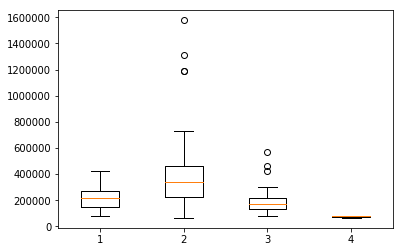

In [471]:
plt.figure()
plt.boxplot(cluster_data)